# The geography of San Francisco crime

The Kaggle San Francisco crime competition challenged Kagglers to predict the category of a crime based on where and when it occured. Let's explore the 'where' aspect of that task to learn about crime in the city and how to succeed in the competition.

First, we'll start with some imports and reading in the training data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

sns.set()
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['axes.titlesize'] = 18

train = pd.read_csv('input/train.csv', parse_dates=['Dates'])

Here's the workhorse of this notebook, a helper function that uses the [Basemap][1] library to plot a heatmap of crime density by category. 

[1]: http://matplotlib.org/basemap/index.html

In [2]:
def plotCrimeDensityByCategoryAx(df=train, categories=None, title='', ax=None, focusPoint = None):
    
    m = Basemap(projection='merc', lon_0=-122.4194, lat_0=37.7749, resolution='h',
                llcrnrlon=-122.541629, 
                llcrnrlat=37.691420,
                urcrnrlon= -122.352458,
                urcrnrlat=37.844216,
                area_thresh = 0.1,
                ax = ax)
    
    _ = m.drawcoastlines()
    
    # Some logic that will allow us to plot all the categories, crimes that fall in
    # into a group of categories, or just a single categoy.
    if categories == None:
        crime = df
    elif type(categories) == list:
        crime = df[df.Category.isin(categories)]
    else:
        crime = df[df.Category == categories]

    lon = crime.X.values
    lat = crime.Y.values
    x,y = m(lon, lat)


    #we want to paint the background of our map with the bluest blue in the
    #spectral_r color map. To do so, we retrieve that value (the value for zero crime density),
    #convert it from rgb to hex, then set it as the background.
    cmap = plt.cm.Spectral_r
    zeroDensity = cmap(0.0)
    zeroDensity = matplotlib.colors.rgb2hex(zeroDensity)
    _ = ax.set_axis_bgcolor(zeroDensity)

    bins=30
    _ = hexBin = m.hexbin(x,y, gridsize=bins,cmap=cmap, ax=ax)
    _ =fig.colorbar(hexBin,label='Crime Density', orientation='horizontal', pad=0.02, ax=ax)

    # if desired, draw an x to emphasise a specific point on the map
    if focusPoint:
        x,y = m(focusPoint[0], focusPoint[1])
        m.scatter(x, y, marker='x', s=80, c='red', linewidths=2) 
        
    
    _ =ax.set_title(title)
    

Let's use our function! Below we plot the density of crime by location for all the categories of crime in the dataset.

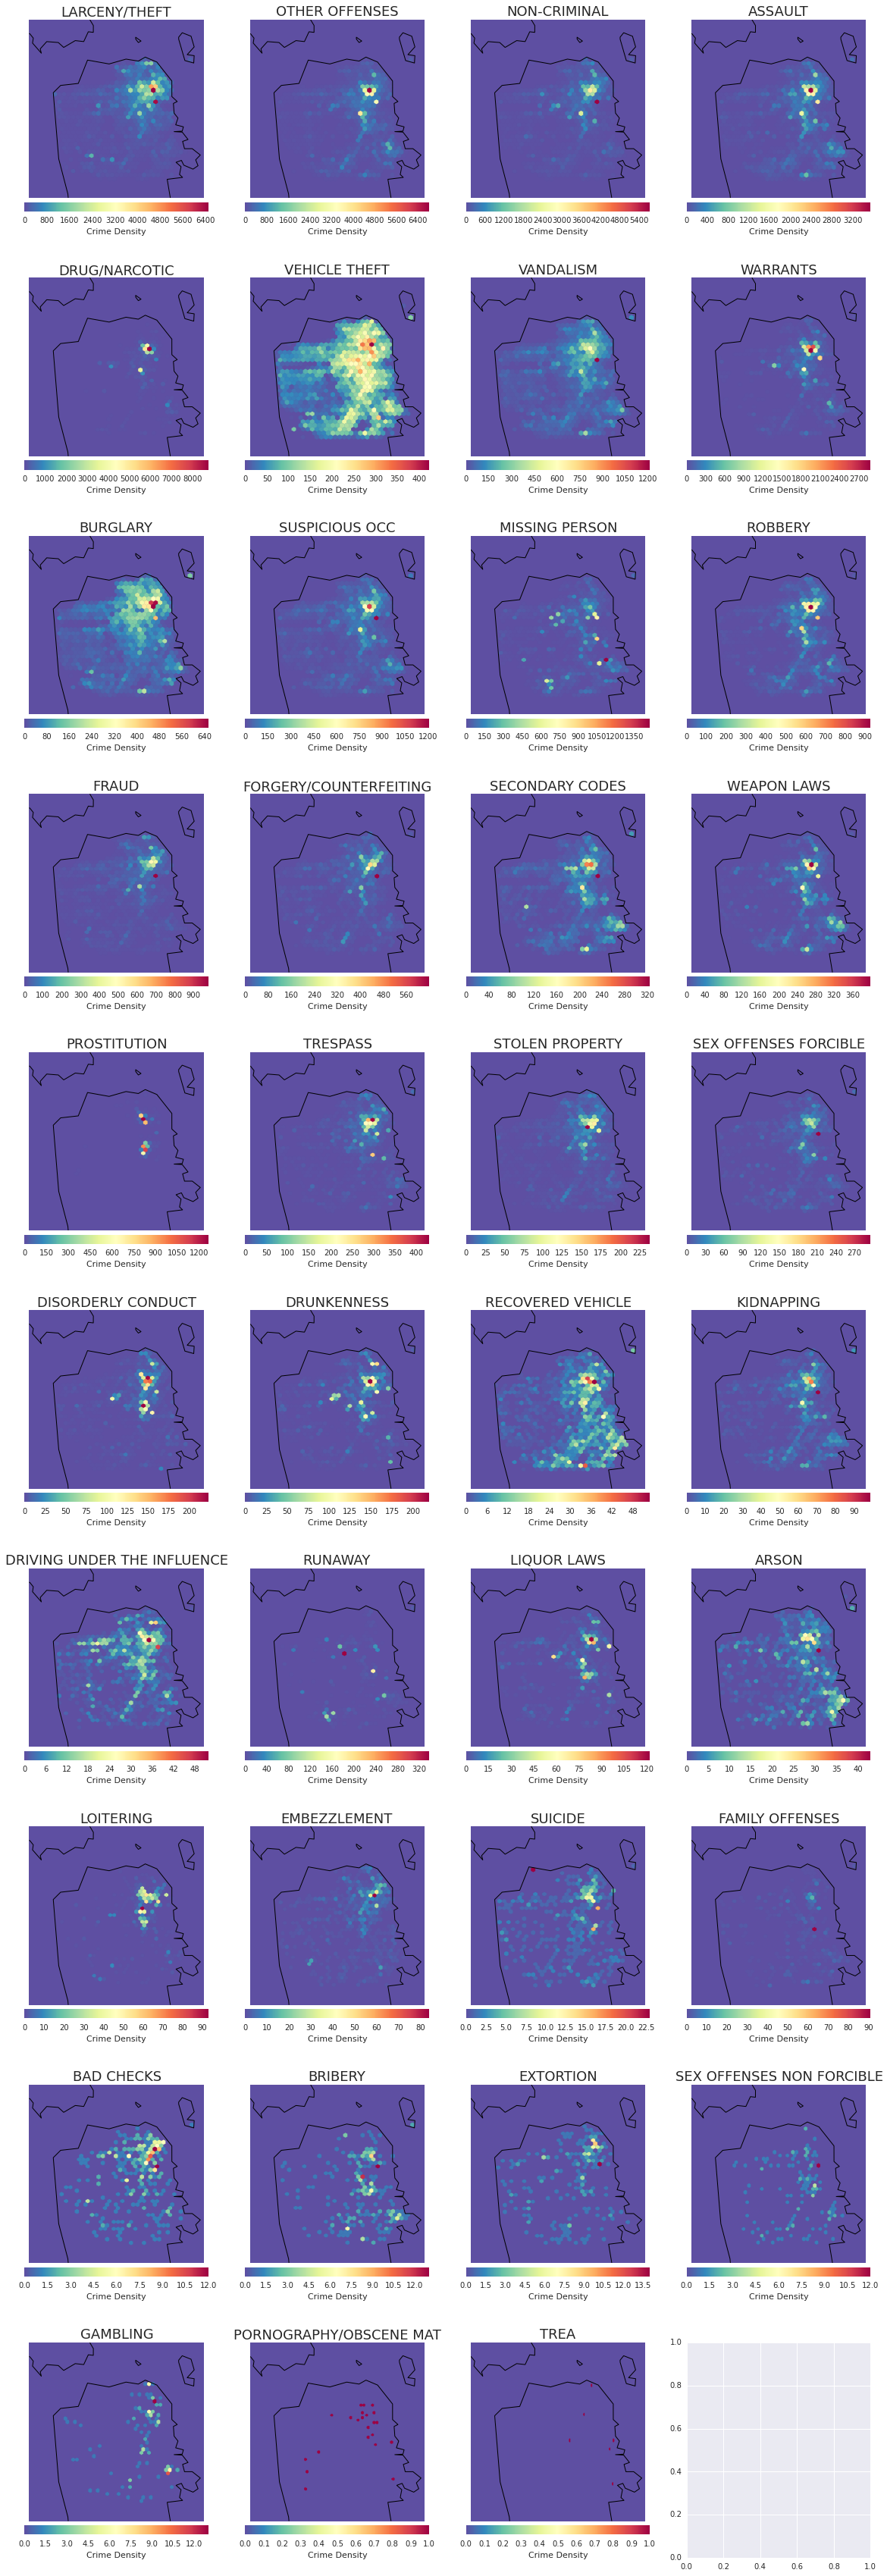

In [7]:
#these three lines calculate the number of columns and rows needed for our plot
numCats = train.Category.nunique()
numCols = 4
numRows = (numCats // numCols) + 1

fig, axes = plt.subplots(numRows, numCols, figsize=(20,60))
for category, ax in zip(train.Category.value_counts().index.values, axes.flat):
    plotCrimeDensityByCategoryAx(categories=category, title=category, ax=ax)

A few observations on the plots above:

- Overall, the hot spot for crime is in the northeast of the city.
- Vehicle theft has a much more diffuse distribution than the other crimes.
- Of crime with significant volume, drugs/narcotics and prositution are the most concentrated.
- What do the maps above have to say about predicting the category of crime? Certain crimes (like prostitution) only occur in certain areas, so location could be helpful in ruling out categories that a crime could belong to. However, most of the crimes are not so concentrated and overlap considerably. Classification may particularly difficult  around the hot spot in the Northeast of the city, because so many different crimes occur frequently there.

Now let's check out the density on different days of the week.

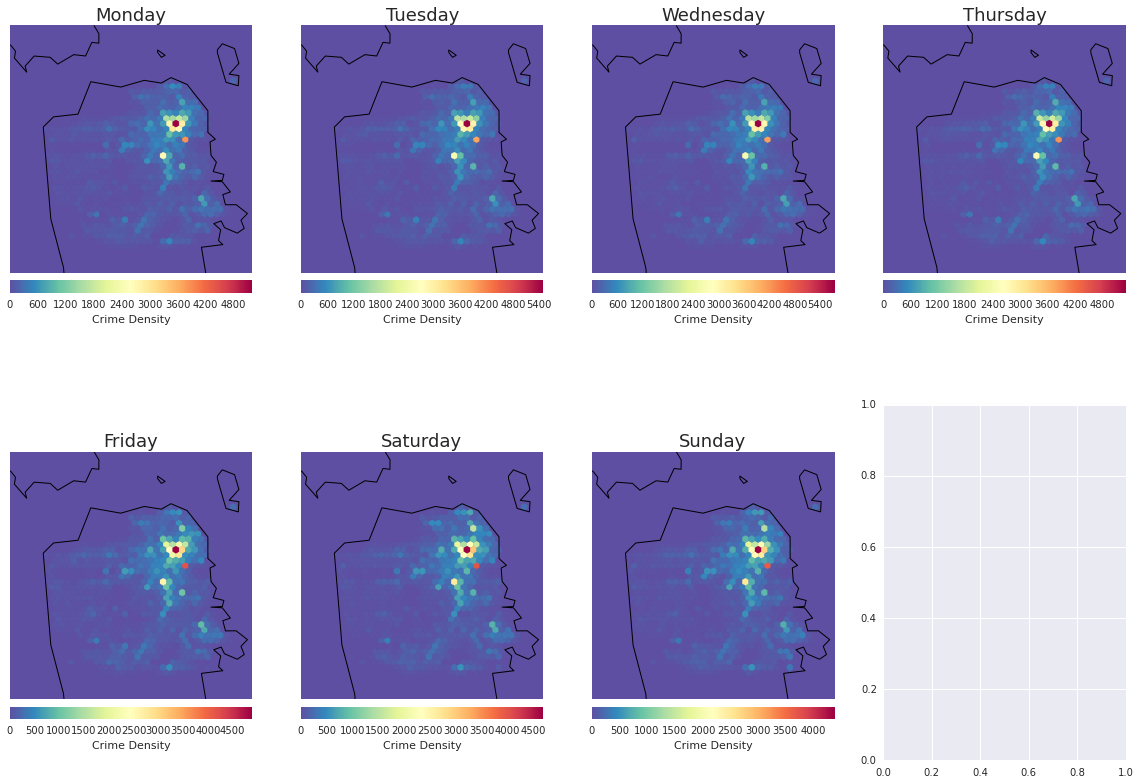

In [9]:
numCols = 4
fig, axes = plt.subplots(2, numCols, figsize=(20,14))

for day, ax in zip(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axes.flat):
    plotCrimeDensityByCategoryAx(df=train[train.DayOfWeek == day], title=day, ax=ax)


Overall, there isn't much change from day to day. Maybe on Friday, Saturday and Sunday there's an uptick in crime in one spot to the northeast of the crime 'hotspot'? 

The x's on the plots below are roughly where I'm referring to.

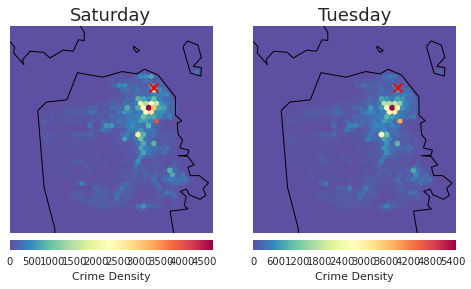

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2)

plotCrimeDensityByCategoryAx(df=train[train.DayOfWeek == 'Saturday'], title='Saturday', ax=ax1, focusPoint=[-122.406853, 37.797942])
plotCrimeDensityByCategoryAx(df=train[train.DayOfWeek == 'Tuesday'], title='Tuesday', ax=ax2, focusPoint=[-122.406853, 37.797942])


Let's look at the crime density by year. Has the distribution changed over the years?

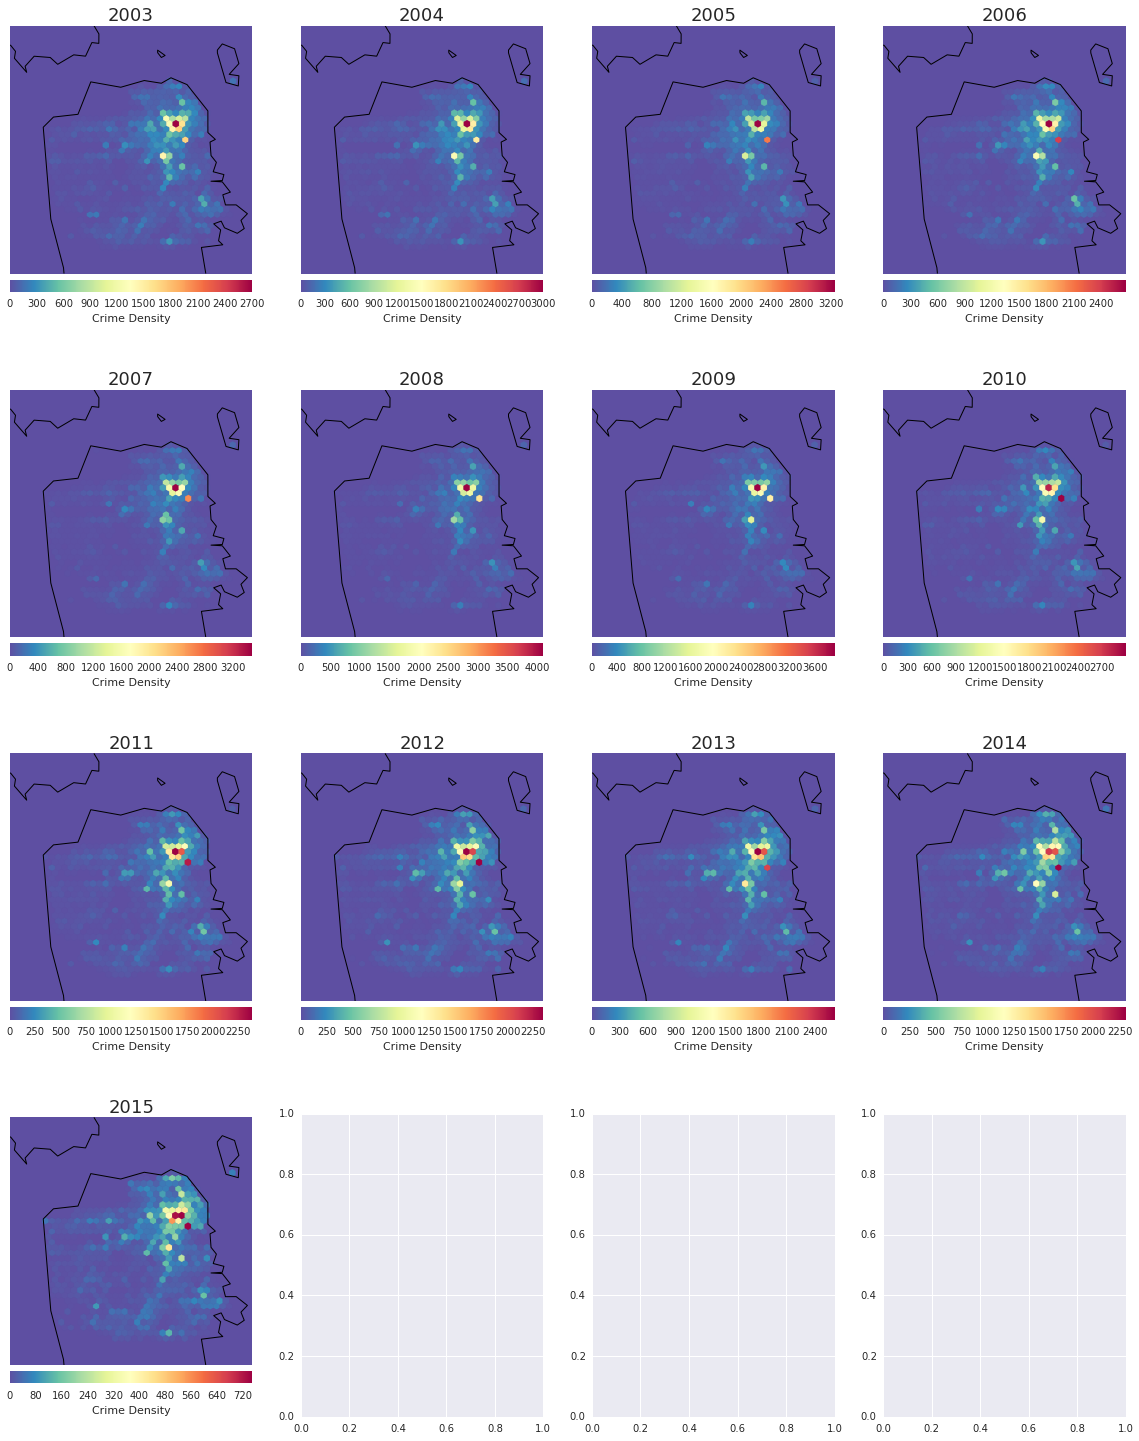

In [11]:
train['year'] = train.Dates.dt.year

numYears = train.year.nunique()
numCols = 4
numRows = (numYears // numCols) + 1 
fig, axes = plt.subplots(numRows, numCols, figsize=(20,25))

for year, ax in zip(np.sort(train.year.unique()), axes.flat):
    plotCrimeDensityByCategoryAx(df=train[train.year == year], title=year, ax=ax)


You could argue that from 2011 to 2015, the crime hot spot in the Northeast of the city seems to have spread out some. However, that's debatable, and the fact that we only have data for part of 2015 makes things murkier.

Now let's try mapping the data by month.

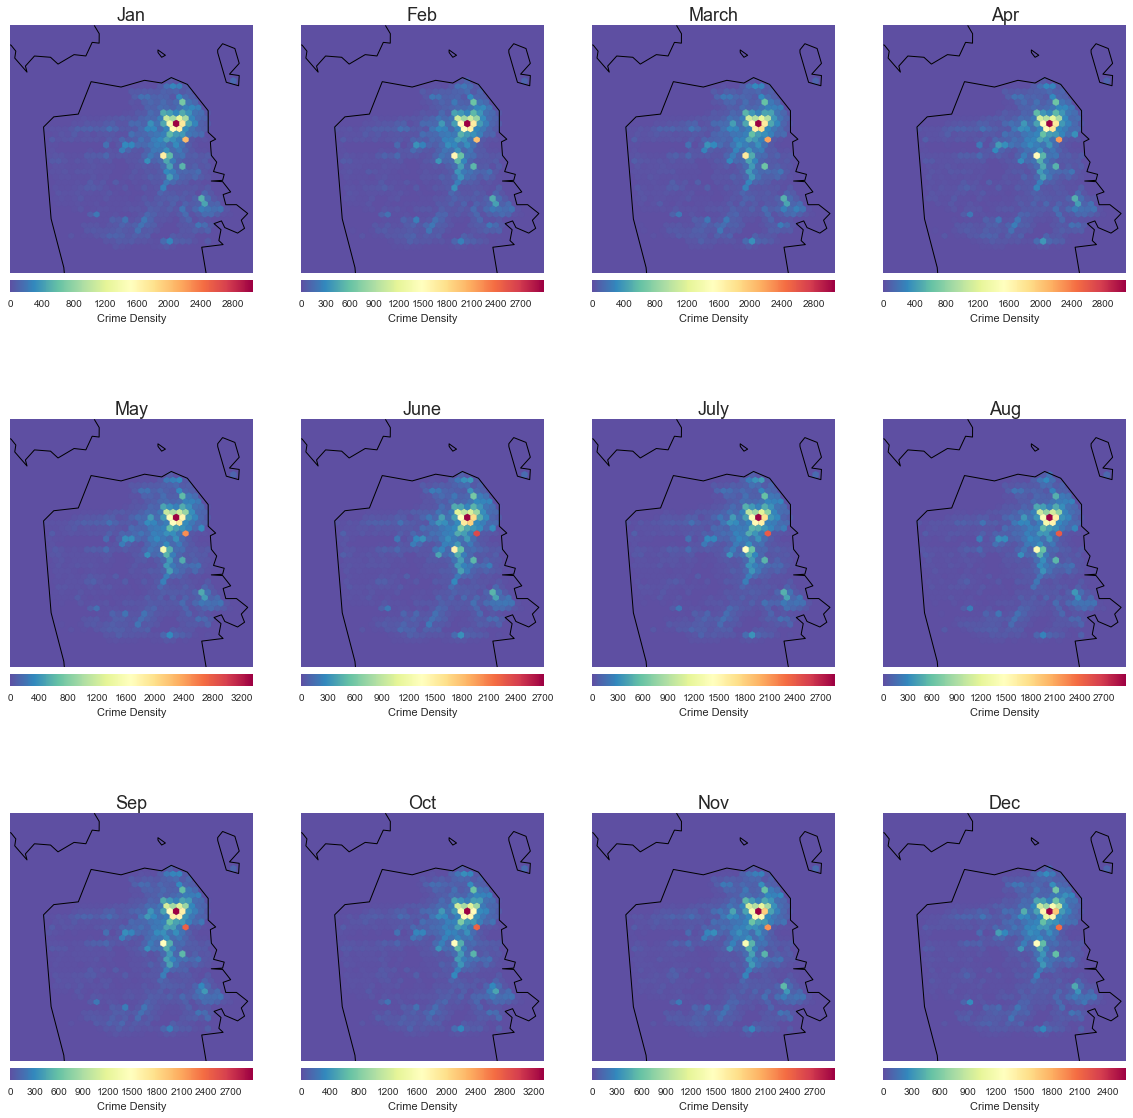

In [13]:
train['month'] = train.Dates.dt.month
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov','Dec']

numMonths = train.month.nunique()
numCols = 4
numRows = (numMonths // numCols) 
fig, axes = plt.subplots(numRows, numCols, figsize=(20,20))

for monthNum, month, ax in zip(np.sort(train.month.unique()), months, axes.flat):
    plotCrimeDensityByCategoryAx(df=train[train.month == monthNum], title=month, ax=ax)


All the months look very similar. I don't see anything to suggest that the density shifts during the year.

Let's change gears now. Out of curiosity, let's look at the location with the most crime. 

In [12]:
byLocation = train.groupby(['X', 'Y']) 
byLocation.size().sort_values(ascending=False)[:10]

X            Y        
-122.403405  37.775421    26354
-122.419658  37.764221     4449
-122.406539  37.756486     3891
-122.407634  37.784189     3170
-122.419672  37.765050     3006
-122.409854  37.783386     2533
-122.406521  37.785063     2329
-122.466205  37.772541     2182
-122.475647  37.728528     2019
-122.426956  37.769247     1991
dtype: int64

That's interesting. The top crime location has 5-6 times the number of crimes than the second location. Let's plot that location.

In [37]:
topX = train.X.value_counts().index[0]
topY = train.Y.value_counts().index[0]
topX, topY

(-122.40340479147899, 37.775420706711003)

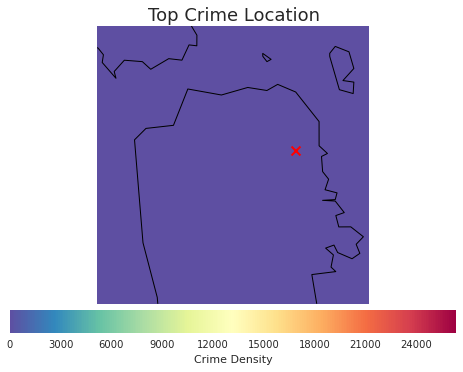

In [38]:
fig, ax = plt.subplots(1,1)
plotCrimeDensityByCategoryAx(df=train[(train.X == topX) & (train.Y == topY)], 
                             title='Top Crime Location', 
                             ax=ax, 
                             focusPoint=[topX, topY])


Hmmm, that's farther south and west than the crime hot spot we saw in the maps above. What's up with that? Maybe Google can help us.

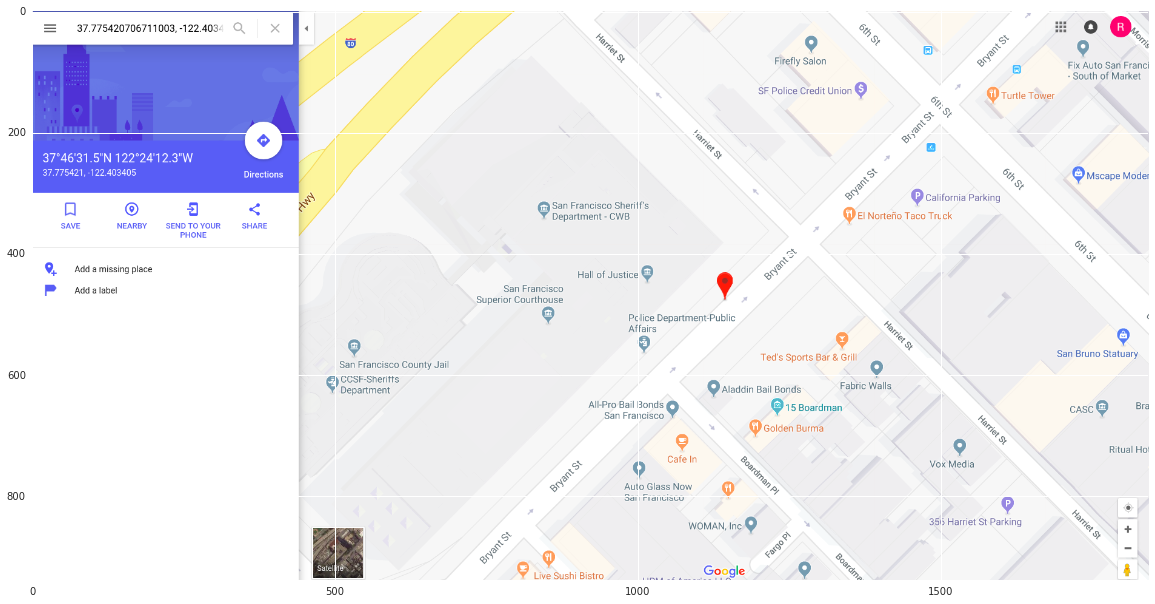

In [39]:
import matplotlib.image as mpimg
topCrimeSpot = mpimg.imread('coords.png')
fig, ax =plt.subplots(1,1, figsize=(20, 20))
_ = plt.imshow(topCrimeSpot)

Ha! It looks like many crimes get reported as occuring at the hall of justice. Maybe that's for administrative reasons when they don't have an actual location?

Let's compare the distributions of crimes reported at that location to the crimes reported at other locations.

In [74]:
hallOfJust = train[(train.X == topX) & (train.Y == topY)]
notHallOfJust = train[(train.X != topX) | (train.Y != topY)]
hallOfJust.shape[0], notHallOfJust.shape[0]

(26354, 851695)

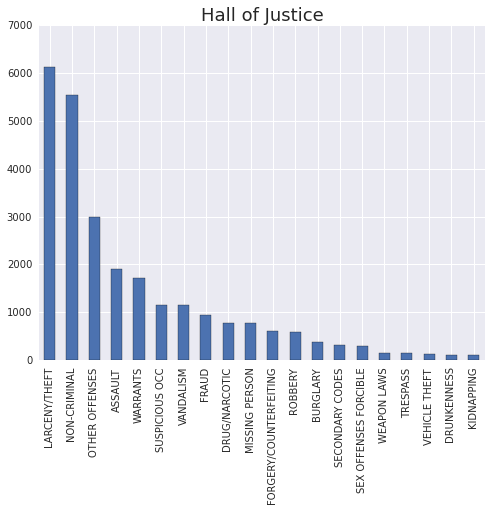

In [75]:
fig, ax =plt.subplots(1,1)
ax.set_title('Hall of Justice')
hallOfJust.Category.value_counts().sort_values(ascending=False).iloc[:20].plot(kind='bar', ax=ax)

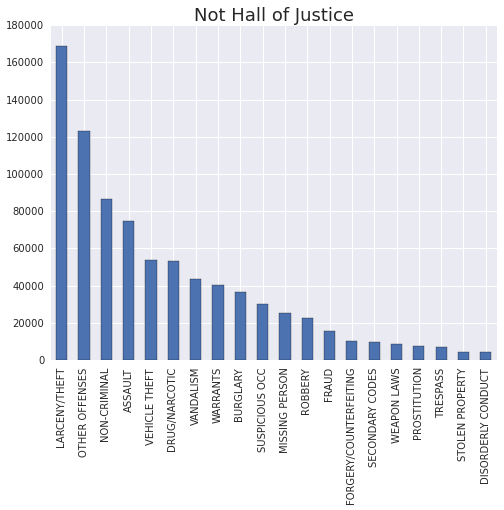

In [77]:
fig, ax =plt.subplots(1,1)
ax.set_title('Not Hall of Justice')
notHallOfJust.Category.value_counts().sort_values(ascending=False).iloc[:20].plot(kind='bar', ax=ax)

In [68]:
test = pd.read_csv('input/test.csv')
test[(test.X == topX) & (test.Y == topY)].shape

(26831, 7)

Looking at the plots above, there are some differences that may make it worth creating a 'hall_of_justice' binary variable before training a classifier. For example, non-criminal offenses comprise a higher percentage of crimes at the hall of justice, while vehicle theft is much rarer.

Now let's look at the real top crime locations (not hall of justice). Grouping the data by address make make things easier. We'll look at which crimes are most prevalent at each location and compare them to the overall data set.

In [78]:
#Note the indexing excludes the hall of justice/SF jail location.
topCrimeAddresses = train.Address.value_counts()[1:6]
topCrimeAddresses

800 Block of MARKET ST      6581
2000 Block of MISSION ST    5097
1000 Block of POTRERO AV    4063
900 Block of MARKET ST      3251
0 Block of TURK ST          3228
Name: Address, dtype: int64

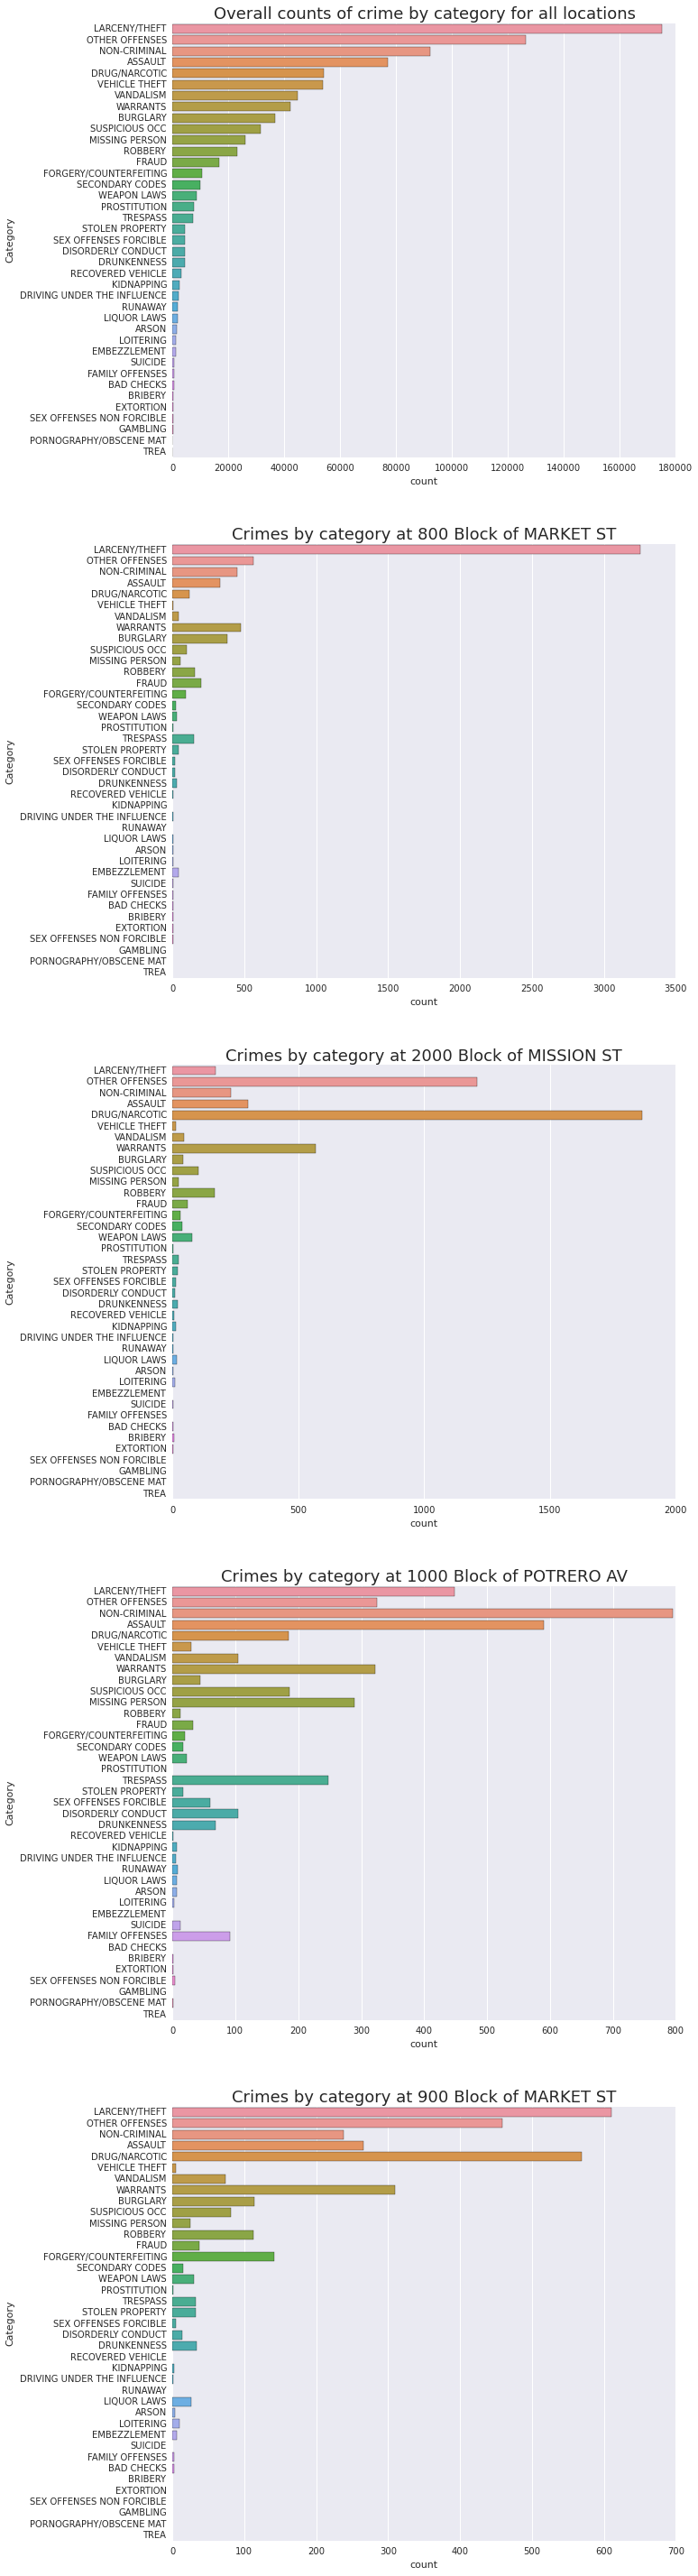

In [79]:
fig, axes = plt.subplots(5, 1, figsize=(10,50))
order = train.Category.value_counts().index.values
sns.countplot(data=train, y='Category', orient='h', order=order, ax=axes.flat[0])
axes.flat[0].set_title('Overall counts of crime by category for all locations')
for addr, ax in zip(topCrimeAddresses.index.values, axes.flat[1:]):
    sns.countplot(data=train[train.Address == addr], y='Category', order=order, orient='h', ax=ax)
    ax.set_title('Crimes by category at {}'.format(addr))

Those graphs are interesting:
* 3 out of the 5 top addresses have disproporitionately high numbers of drug offenses.
* Why would the 900 block of Market St. have so many drug offenses while the 800 block does not?
* The 1000 block of Potrero Av. has an unusually high number of non-criminal offenses and assaults.
 